# Engenius '20 - Sales Prediction

## Overview

The Main goal is to predict the quantities sold of a set of products within a 4 months time frame.

# Table of Contents

- Exploratory Data Analysis
    -  Missing & Erroneous Value Treatment
    -  Distribution of Products Sold
    - Product Insights
- Product And Sector Investigation
- Missing & Erroneous Value Treatment
- Acquisition of Socio-Economical And Demographical Data
    - Gross Domestic Product By City
    - Life Expectancy By City
    - Population By City
    - Population Growth Rate And Population Density By City
    - Retail Purchases Monthly Change With WAT Without Seasonal Influences
- Feature Creation
- Resources

# Exploratory Data Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import math

product_sheets = ['PRODUCT_A', 'PRODUCT_B', 'PRODUCT_C', 'PRODUCT_V', 'PRODUCT_X']
data = {}

In [2]:

for s in product_sheets:
    data[s] = pd.read_excel('datasets/Data2017-2019.xls', s)
    

In [3]:
# merge data frames for all 5 products vertically
df_all5 = data[product_sheets[0]]
for i,s in enumerate(product_sheets):
    if i != 0:
        df_all5 = df_all5.append(data[s], ignore_index=True)


In [4]:
df_all5.shape

(58032, 5)

In [5]:
df_all5.Product.value_counts()

PRODUCT_C    17980
PRODUCT_B    17962
PRODUCT_A    17371
PRODUCT_X     2920
PRODUCT_V     1799
Name: Product, dtype: int64

### Missing & Erroneous Value Treatment
- ratio of null values
  No null values as seen below

In [105]:
(df_all5.isnull().sum() / df_all5.shape[0])

Year        0.0
Period      0.0
Product     0.0
Province    0.0
Quantity    0.0
dtype: float64

In [83]:
def internationalize_the_text(text):
    result = text.upper().replace('Ü','U').replace('Ğ','G').replace('İ','I').replace('Ş','S').replace('Ç','C').replace('Ö','O').replace('AFYONKARAHISAR', 'AFYON').replace('MERSIN', 'ICEL')
    return result

#### ratio of transactions (sales) with negative quantities
 - probably product return

In [8]:
(df_all5[df_all5.Quantity < 0].shape[0] / df_all5.shape[0])

0.0016197959746346844

In [9]:
data_sorted = df_all5.sort_values(by=['Period', 'Province', 'Product']).reset_index(drop=True)
data_sorted.head(5)

,Year,Period,Product,Province,Quantity
0,2017,201701,PRODUCT_A,ADANA,11
1,2017,201701,PRODUCT_A,ADANA,25
2,2017,201701,PRODUCT_A,ADANA,54
3,2017,201701,PRODUCT_A,ADANA,17
4,2017,201701,PRODUCT_A,ADANA,30


In [10]:
print('there is a typo in province names')
len(data_sorted.Province.unique())

there is a typo in province names


82

In [11]:
data_sorted = df_all5.sort_values(by=['Period', 'Province', 'Product']).reset_index(drop=True)
data_sorted.head(5)

,Year,Period,Product,Province,Quantity
0,2017,201701,PRODUCT_A,ADANA,11
1,2017,201701,PRODUCT_A,ADANA,25
2,2017,201701,PRODUCT_A,ADANA,54
3,2017,201701,PRODUCT_A,ADANA,17
4,2017,201701,PRODUCT_A,ADANA,30


In [12]:
# fixes ıstanbul typo
data_sorted['Province'] = data_sorted.Province.apply(lambda x: 'İSTANBUL' if x == 'ISTANBUL' else x)
data_sorted['Province'] = data_sorted.Province.apply(lambda x: 'ÇANAKKKALE' if x == 'ÇANAKKALE' else x)

In [13]:
#aggragate products sold
data_aggregated = data_sorted.groupby(['Period', 'Province', 'Product'])['Quantity'].sum().reset_index()
data_aggregated.head(8)

,Period,Province,Product,Quantity
0,201701,ADANA,PRODUCT_A,346
1,201701,ADANA,PRODUCT_B,4838
2,201701,ADANA,PRODUCT_C,1004
3,201701,ADANA,PRODUCT_V,20
4,201701,ADANA,PRODUCT_X,910
5,201701,ADIYAMAN,PRODUCT_A,36
6,201701,ADIYAMAN,PRODUCT_B,45
7,201701,ADIYAMAN,PRODUCT_C,206


In [14]:
data_aggregated.shape

(13343, 4)

### Filling mising sample rows due to no sale

In [15]:
data_aggregated.head()

,Period,Province,Product,Quantity
0,201701,ADANA,PRODUCT_A,346
1,201701,ADANA,PRODUCT_B,4838
2,201701,ADANA,PRODUCT_C,1004
3,201701,ADANA,PRODUCT_V,20
4,201701,ADANA,PRODUCT_X,910


In [16]:
cr_indices = data_aggregated.set_index(['Period', 'Province', 'Product']).index.tolist()
all_possible_combinations = []
# let's populate all possible index value combinations (vertical)
for period in data_aggregated.Period.value_counts().index.tolist():
    for province in data_aggregated.Province.value_counts().index.tolist():
        for product in data_aggregated.Product.value_counts().index.tolist():
            all_possible_combinations.append((period, province, product))

# detecting missing ones
missing_index_combinations = all_possible_combinations
for e in cr_indices:
    missing_index_combinations.remove(e)
len(missing_index_combinations)

#populating the missing entries
data_missing = pd.DataFrame(columns=['Period', 'Province', 'Product', 'Quantity'])
for i,m in enumerate(missing_index_combinations):
    if i == 0:
        print(m)
    data_missing.loc[i] = list(m) + [0]
    
print(data_missing.head())
print(data_missing.shape)
data_aggregated = data_aggregated.append(data_missing).sort_values(by=['Period', 'Province', 'Product'], ascending=True).reset_index(drop=True)
data_aggregated.tail()

(201910, 'MALATYA', 'PRODUCT_V')
   Period Province    Product Quantity
0  201910  MALATYA  PRODUCT_V        0
1  201910   BURDUR  PRODUCT_V        0
2  201910    SİVAS  PRODUCT_V        0
3  201910   MARDIN  PRODUCT_V        0
4  201910     BOLU  PRODUCT_V        0
(1237, 4)


,Period,Province,Product,Quantity
14575,201912,ŞIRNAK,PRODUCT_A,28
14576,201912,ŞIRNAK,PRODUCT_B,144
14577,201912,ŞIRNAK,PRODUCT_C,323
14578,201912,ŞIRNAK,PRODUCT_V,0
14579,201912,ŞIRNAK,PRODUCT_X,27


#### The most common cities which did not received any specific product in a month
 - The small towns surely have a weak impulse in demand and low inventory turnover rate.

In [17]:
data_missing.Province.value_counts()[:8]

ARDAHAN     51
HAKKARİ     51
TUNCELİ     46
BAYBURT     42
SİİRT       41
IĞDIR       36
KİLİS       36
ERZİNCAN    35
Name: Province, dtype: int64

#### The most common products which did not delivered to any specific city in a month
- Product V -the vitamin- appears to be the most dispensable product of all 5.
- Or it might be due to tug of wars, competetive weaknes and/or minor market share in terms of that very product category.

In [18]:
data_missing.Product.value_counts()

PRODUCT_V    1153
PRODUCT_A      48
PRODUCT_X      32
PRODUCT_B       4
Name: Product, dtype: int64

In [19]:
data_aggregated.to_csv('datasets/data_aggregated.csv', index=False)

#### Checkpoint-1

In [20]:
data_aggregated = pd.read_csv('datasets/data_aggregated.csv')

In [21]:
data_aggregated.head()

,Period,Province,Product,Quantity
0,201701,ADANA,PRODUCT_A,346
1,201701,ADANA,PRODUCT_B,4838
2,201701,ADANA,PRODUCT_C,1004
3,201701,ADANA,PRODUCT_V,20
4,201701,ADANA,PRODUCT_X,910


In [22]:
# standardizes all province names for further usage and make easy to integrate more datasets
data_aggregated.Province = data_aggregated.Province.apply(lambda x: internationalize_the_text(x))

In [23]:
data_aggregated.shape

(14580, 4)

### Distribution of Products Sold

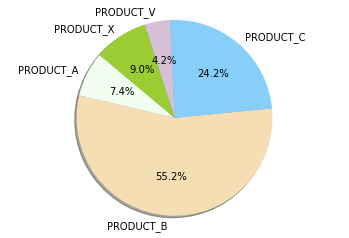

Product
PRODUCT_A     576747
PRODUCT_B    4291439
PRODUCT_C    1879572
PRODUCT_V     324499
PRODUCT_X     696845
Name: Quantity, dtype: int64

In [24]:
labels = product_sheets
sizes = data_aggregated.groupby(['Product'])['Quantity'].sum().sort_index().tolist()
colors = ['honeydew', 'wheat', 'lightskyblue', 'thistle', 'yellowgreen']
#explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

data_aggregated.groupby(['Product'])['Quantity'].sum().sort_index()

### Geographical Distribution of Sales By City

In [25]:
#cities world-countries.json > the coordinates file is cited (please look at Resources #1)
turkey_cities_json_source = 'geo_json/tr-cities-utf8.json'

In [26]:
data_heat_general = data_aggregated[['Province', 'Quantity']]
data_heat_general = data_heat_general.groupby(['Province'])['Quantity'].sum().reset_index()
data_heat_general['Province'] = data_heat_general['Province'].apply(lambda x: x.capitalize().replace('i̇', 'i')) 
data_heat_general.head()

data_heat_general.sort_values(by=['Province'], ascending=True).reset_index(drop=True)[:5]

,Province,Quantity
0,Adana,202564
1,Adiyaman,21711
2,Afyon,60131
3,Agri,47827
4,Aksaray,46315


In [27]:
# matching and correcting city names
city_correction_dict = {}
city_correction_dict['Adiyaman'] = 'Adıyaman'
city_correction_dict['Agri'] = 'Ağrı'
city_correction_dict['Aydin'] = 'Aydın'
city_correction_dict['Balikesir'] = 'Balıkesir'
city_correction_dict['Bartin'] = 'Bartın'
city_correction_dict['Bingol'] = 'Bingöl'
city_correction_dict['Corum'] = 'Çorum'
city_correction_dict['Canakkkale'] = 'Çanakkale'
city_correction_dict['Cankiri'] = 'Çankırı'
city_correction_dict['Diyarbakir'] = 'Diyarbakır'
city_correction_dict['Duzce'] = 'Düzce'
city_correction_dict['Elazig'] = 'Elazığ'
city_correction_dict['Eskisehir'] = 'Eskişehir'
city_correction_dict['Gumushane'] = 'Gümüşhane'
city_correction_dict['Igdir'] = 'Iğdır'
city_correction_dict['Istanbul'] = 'İstanbul'
city_correction_dict['Izmir'] = 'İzmir'
city_correction_dict['Karabuk'] = 'Karabük'
city_correction_dict['Kahramanmaras'] = 'Kahramanmaraş'
city_correction_dict['Kirikkale'] = 'Kırıkkale'
city_correction_dict['Kirklareli'] = 'Kırklareli'
city_correction_dict['Kirsehir'] = 'Kırşehir'
city_correction_dict['Kutahya'] = 'Kütahya'
city_correction_dict['Icel'] = 'Mersin'
city_correction_dict['Mugla'] = 'Muğla'
city_correction_dict['Nevsehir'] = 'Nevşehir'
city_correction_dict['Nigde'] = 'Niğde'
city_correction_dict['Sanliurfa'] = 'Şanlıurfa'
city_correction_dict['Sirnak'] = 'Şırnak'
city_correction_dict['Mus'] = 'Muş'
city_correction_dict['Tekirdag'] = 'Tekirdağ'
city_correction_dict['Usak'] = 'Uşak'


data_heat_general['Province'] = data_heat_general['Province'].apply(lambda x: city_correction_dict[x] if x in city_correction_dict.keys() else x) 

In [28]:
data_heat_general['Quantity'] = data_heat_general['Quantity'].apply(lambda x: math.log(x+0.001))
data_heat_general.head(10)

,Province,Quantity
0,Adana,12.218811
1,Adıyaman,9.985574
2,Afyon,11.004281
3,Ağrı,10.775346
4,Aksaray,10.743221
5,Amasya,10.457574
6,Ankara,13.036670
7,Antalya,12.732808
8,Ardahan,7.971431
9,Artvin,9.007367


In [29]:
# An open source geographical heat map library used for data visualization (please look at Resources #2)
import folium

turkey_heat_map_general_products_sold_by_city = folium.Map(
    location=[39.855555, 34.665873],
    #tiles='Stamen Terrain',
    zoom_start=5
)

turkey_heat_map_general_products_sold_by_city.choropleth(geo_data=turkey_cities_json_source, data=data_heat_general, columns=['Province', 'Quantity'], key_on='feature.properties.name',
                         fill_color='OrRd', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)

turkey_heat_map_general_products_sold_by_city

/home/a/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Product Insights

In [30]:
# plots the historical sales data for the wanted product
import seaborn as sns
def plot_historical_sales_data_for_the_product_wanted(product_name):
    data_sales_product = data_aggregated[data_aggregated['Product'] == product_name].groupby(['Period'])['Quantity'].sum().reset_index()
    data_sales_product['Period'] = data_sales_product['Period'].astype(str)
    fig,ax = plt.subplots(figsize=(12,4))
    ax.set_xticklabels(range(0,36))
    sns.lineplot(x="Period", y="Quantity", ax=ax, data=data_sales_product)
    plt.xticks(rotation=15)
    plt.title(product_name + ' Sales')
    plt.show()
    data_sales_product.set_index('Period').transpose()

In [31]:
#scatter plot Province/Quantity
def plot_scattered_mean_sales_by_city(product_name):
    data_province_quantity = data_aggregated[data_aggregated['Product'] == product_name].groupby(['Province'])['Quantity'].mean().reset_index()
    max_avg = data_province_quantity.Quantity.max()
    print("max_avg: {}".format(max_avg))
    print(data_province_quantity.sort_values(by=['Quantity'], ascending=False).head())
    
    var = 'Province'
    series_var = data_province_quantity[var].copy()
    for i in range(0, len(series_var)):
        series_var[i] = i+1
    
    data = pd.concat([data_province_quantity['Quantity'], series_var], axis=1)
    data.plot.scatter(x=var, y='Quantity', ylim=(0,max_avg*1.1));
    return data_province_quantity

In [32]:
def display_pie_chart(data_province_quantity):
    labels = data_province_quantity['Province'].tolist()
    sizes = data_province_quantity['Quantity'].tolist()
    labels = minor_label_filter(labels, sizes, 0.03)
    colors = ['honeydew', 'wheat', 'lightskyblue', 'thistle', 'yellowgreen']
    explode = (0.1, 0)  # explode 1st slice

    plt.pie(sizes, labels=labels, colors=colors, autopct=func_autopct, shadow=True, startangle=150)

    plt.axis('equal')
    plt.show()
    
def func_autopct(pct):
    return ('%.2f' % pct) if pct > 3 else ''
def minor_label_filter(labels, sizes, threshold_percent):
    for i,x in enumerate(sizes):
        if x/sum(sizes) < threshold_percent:
            labels[i] = ''
    return labels

## Product A

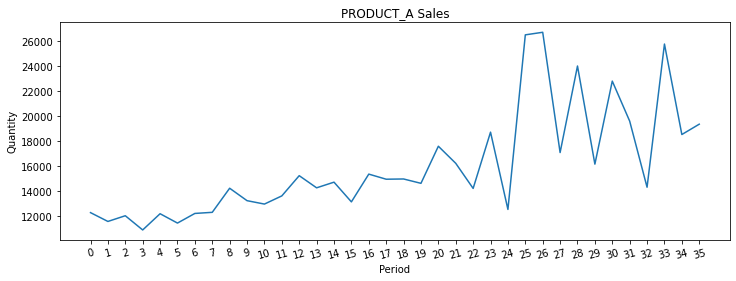

In [33]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_A')

max_avg: 3987.6666666666665
    Province     Quantity
40  ISTANBUL  3987.666667
6     ANKARA  1698.250000
41     IZMIR  1083.416667
7    ANTALYA   827.305556
0      ADANA   483.055556


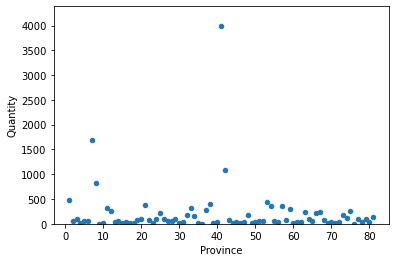

In [34]:
data_last_product = plot_scattered_mean_sales_by_city('PRODUCT_A')

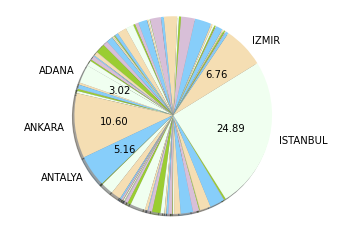

In [35]:
display_pie_chart(data_last_product)

## Product B

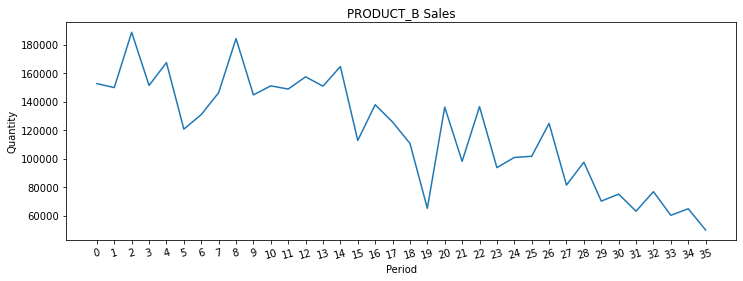

In [36]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_B')

## Product C

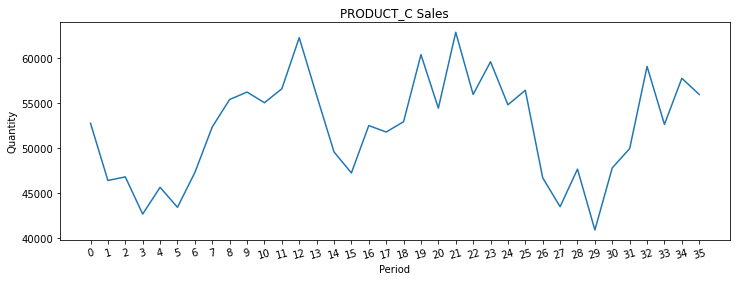

In [37]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_C')

## Product X

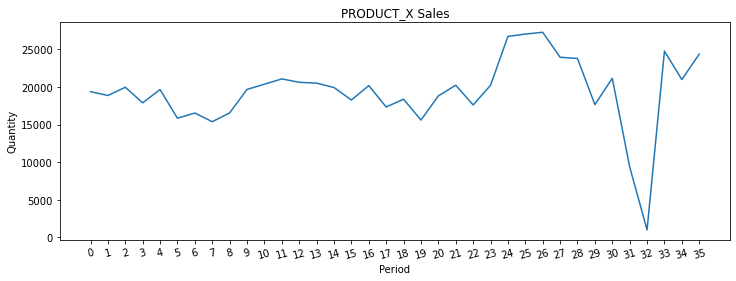

In [38]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_X')

## Product V

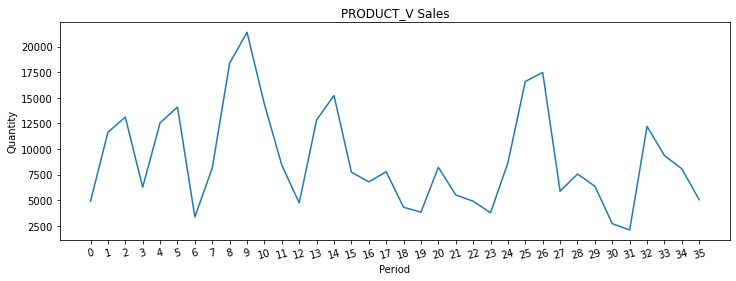

In [39]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_V')

# Product And Sector Investigation

# Acquisition of Socio-Economical And Demographical Data

### Gross Domestic Product By City
This demonstrates the accumulated wealth and flourishing of the city

In [40]:
# (please look at Resources #7)
data_gdp_by_city = pd.read_csv('datasets/tuik/gdp_by_city_2018.csv', delimiter='|')

In [41]:
data_gdp_by_city = data_gdp_by_city.transpose().reset_index().rename(columns={0: 'GDP by City', 'index': 'Province'})
data_gdp_by_city['city_id'] = pd.to_numeric(data_gdp_by_city['Province'].apply(lambda x: x.split('-')[1]))
data_gdp_by_city['city_id'] = data_gdp_by_city['city_id'].apply(lambda x: x-1)
data_gdp_by_city['Province'] = data_gdp_by_city['Province'].apply(lambda x: x.split('-')[0])
data_gdp_by_city = data_gdp_by_city.set_index('city_id').sort_index()

In [42]:
data_gdp_by_city.head(3)

,Province,GDP by City
city_id,,
0,Adana,72187342.0
1,Adıyaman,13958454.0
2,Afyonkarahisar,22804455.0


### Life Expectancy By City
This may indicate how much does an ordinary citizen cares of his/her health in that particular city

In [43]:
# (please look at Resources #8)
data_life_expectancy_by_city = pd.read_csv('datasets/tuik/life_expectancy_by_city.csv')
data_life_expectancy_by_city.tail(3)

,Province,life_expectancy
78,Kilis,76.1
79,Osmaniye,78.0
80,Düzce,77.5


### Population By City
This feature undisputedly should have a positive correlation with the number of products sold in that city.

In [44]:
# (please look at Resources #9)
data_population_by_city = pd.read_csv('datasets/tuik/population_by_city_2018.csv')
data_population_by_city['population'] = pd.to_numeric(data_population_by_city['population'].apply(lambda x: x.replace(" ", "")))
data_population_by_city.head(3)

,Province,population
0,Adana,2220125
1,Adıyaman,624513
2,Afyonkarahisar,725568


### Population Growth Rate And Population Density By City
Since it reveals the number of newborns and toddlers, Population Growth Rate most probably contributes to the performance of our models especially for PRODUCT_C to a certain extend.

In [45]:
# ((please look at Resources #10)
data_population_growth_rate_density_by_city = pd.read_csv('datasets/tuik/pop_density_and_growth_rate.csv')
#data_population_by_city['population'] = pd.to_numeric(data_population_by_city['population'].apply(lambda x: x.replace(" ", "")))
data_population_growth_rate_density_by_city.head(3)

,Province,pop_growth_rate_2016_2017,pop_growth_rate_2017_2018,pop_growth_rate_2018_2019,pop_density_2017,pop_density_2018,pop_density_2019
0,Adana,6.7,1.6,8.0,159,160,161
1,Adıyaman,7.5,15.2,3.1,87,89,89
2,Afyonkarahisar,1.6,13.7,5.4,50,51,51


### Retail Purchases Monthly Change With WAT Without Seasonal Influences (Base Prices - 2015)

- This data may demonstrate consumer behaviour in some sense.

- The monthly increase of 13.2% is remarkable for March, 2020 in which the first covid-19 case is announced in Turkey.

- We did not included online purchase data, since online drug purchases are strictly forbidden by local (Turkish) laws and regulations. In accordance with the law no. 6197, pharmacies are not even allowed to publish websites.

(please look at Resources #20 and #21)


In [46]:
# (please look at Resources #19)
data_monthly_retail_purchases_change = pd.read_csv('datasets/tuik/retail_purchases_monthly_with_wat_without_seasonal_influences_base_2015_prices.csv', delimiter='|')
data_monthly_retail_purchases_change = data_monthly_retail_purchases_change.set_index(['year']).transpose()
data_monthly_retail_purchases_change

year,2017,2018,2019,2020
01,0.1,2.2,-0.3,0.3
02,0.2,-1.3,-0.4,3.6
03,-0.1,0.7,2.5,13.2
04,1.5,0.7,-0.2,-4.2
05,1.4,0.8,1.4,NaN
06,-1.0,-1.7,-0.3,NaN
07,0.1,0.0,0.0,NaN
08,4.9,0.9,1.5,NaN
09,-4.4,-2.8,1.1,NaN
10,4.0,-3.3,0.2,NaN


# Feature Creation

## Acquiring Infant and Toddlers Distrubution By City (0-4) by processing children count by age and city

- This age bracket strongly correlates peculiarly with Product C as stressed in EnGenius '20 presentation document.   (please look at Resources #11)

In [47]:
# (please look at Resources #12)
data_children_count_by_age_and_city = pd.read_csv('datasets/tuik/children_number_by_age_and_city.csv', delimiter='|')
data_children_count_by_age_and_city = data_children_count_by_age_and_city.drop(columns=['Satırlar', 'Unnamed: 84'])
data_children_count_by_age_and_city = data_children_count_by_age_and_city.rename(columns={"Unnamed: 1": "category", "Unnamed: 2": "year"})
data_children_count_by_age_and_city['category'] = data_children_count_by_age_and_city['category'].fillna(method='ffill')
data_children_count_by_age_and_city['age'] = pd.to_numeric(data_children_count_by_age_and_city['category'].apply(lambda x: x.split(':')[2]))
data_children_count_by_age_and_city['gender'] = data_children_count_by_age_and_city['category'].apply(lambda x: (x.split(' ')[0]).split(':')[1])

data_infants_and_toddlers = data_children_count_by_age_and_city[data_children_count_by_age_and_city.age < 5].drop(columns=['category', 'gender', 'age']).groupby(['year']).sum().reset_index()
data_infants_and_toddlers = data_infants_and_toddlers.rename(columns={'year': 'Province'}).set_index(['Province']).transpose()
data_infants_and_toddlers = data_infants_and_toddlers.reset_index()
data_infants_and_toddlers['Province'] = data_infants_and_toddlers['index'].apply(lambda x: x.split('-')[0])
data_infants_and_toddlers['index'] = pd.to_numeric(data_infants_and_toddlers['index'].apply(lambda x: x.split('-')[1]))
data_infants_and_toddlers = data_infants_and_toddlers.set_index('Province').sort_values(by=['index'], ascending=True)
data_infants_and_toddlers.head(3)

Province,index,2017,2018,2019
Province,,,,
Adana,1,190594.0,187842.0,181508.0
Adıyaman,2,62631.0,62989.0,61142.0
Afyonkarahisar,3,52997.0,52944.0,51359.0


## Acquiring Elderly Male Population Distrubution By City And Age Groups

- These age groups for male citizens substantially correlates especially with Product X as indicated in EnGenius '20 presentation document.  (please look at Resources #11)
- As revealed with our Investigation, Product X is most probably XALFU XL product which is firstly lisanced by 'Eczacıbaşı Ilaç Pazarlama' on 01/13/2016.  (please look at Resources #16)
- The elderly males who suffer from prostate enlargement in general are on medivation with XALFU XL. (Zorlu et al., 2014) (please look at Resources #13, #14)

In [48]:
# (please look at Resources #22)
data_by_city_gender_and_age_groups = pd.read_csv('datasets/tuik/population_by_city_gender_and_age_groups.csv', delimiter='|')
data_by_city_gender_and_age_groups = data_by_city_gender_and_age_groups.rename(columns={"Unnamed: 0": "year", "Unnamed: 1": "city_id"}).drop(columns=['Unnamed: 40'])
data_by_city_gender_and_age_groups['year'] = data_by_city_gender_and_age_groups['year'].fillna(method='ffill')
data_by_city_gender_and_age_groups['Province'] = data_by_city_gender_and_age_groups['city_id'].apply(lambda x: x.split('-')[0])
data_by_city_gender_and_age_groups['city_id'] = data_by_city_gender_and_age_groups['city_id'].apply(lambda x: x.split('-')[1])
data_by_city_gender_and_age_groups = data_by_city_gender_and_age_groups.set_index('Province').sort_index()

data_by_city_gender_and_age_groups.head()

,year,city_id,Erkek ve 0-4,Erkek ve 10-14,Erkek ve 15-19,Erkek ve 20-24,Erkek ve 25-29,Erkek ve 30-34,Erkek ve 35-39,Erkek ve 40-44,...,Kadın ve 50-54,Kadın ve 55-59,Kadın ve 5-9,Kadın ve 60-64,Kadın ve 65-69,Kadın ve 70-74,Kadın ve 75-79,Kadın ve 80-84,Kadın ve 85-89,Kadın ve 90+
Province,,,,,,,,,,,,,,,,,,,,,
Adana,2017.0,1,97512.0,93408.0,94576.0,83854.0,81203.0,84918.0,89858.0,79611.0,...,64703.0,54859.0,91647.0,47294.0,35249.0,23325.0,16475.0,10134.0,5981.0,2453.0
Adana,2019.0,1,92880.0,96793.0,89973.0,81930.0,79820.0,81952.0,88602.0,81661.0,...,62905.0,60161.0,92347.0,48575.0,38304.0,27956.0,17199.0,10966.0,6322.0,2843.0
Adana,2018.0,1,96048.0,95457.0,91990.0,80062.0,79326.0,82966.0,89395.0,80171.0,...,63809.0,57464.0,91203.0,47310.0,36409.0,25034.0,16748.0,10415.0,6232.0,2631.0
Adıyaman,2018.0,2,32473.0,30346.0,30310.0,25557.0,23911.0,23760.0,23287.0,19710.0,...,13215.0,11902.0,29255.0,9712.0,8964.0,6915.0,4598.0,3065.0,1781.0,1210.0
Adıyaman,2019.0,2,31328.0,30335.0,29195.0,25753.0,24037.0,23655.0,23084.0,19849.0,...,13312.0,12307.0,29630.0,9984.0,9001.0,7428.0,4832.0,3150.0,1788.0,1205.0


### Now Let's create a new dataset and extract the most useful information for our model into that.

In [49]:
data_male_elderly_pop_by_city_and_age_group = pd.DataFrame([pd.to_numeric(data_by_city_gender_and_age_groups['city_id'].unique()), data_by_city_gender_and_age_groups.index.unique()]).transpose().rename(columns={0: 'city_id', 1: 'Province'}).set_index('Province').sort_values(by=['city_id'], ascending=True)
gender_label = 'Erkek ve '

years = [2017, 2018, 2019]
for y in years:
    data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+'90+'+'_male'] = data_by_city_gender_and_age_groups[data_by_city_gender_and_age_groups.year == y][gender_label+'90+']
    for i in range(10,18):
        data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+str(i*5)+'-'+str((i+1)*5-1)+'_male'] = data_by_city_gender_and_age_groups[data_by_city_gender_and_age_groups.year == y][gender_label+str(i*5)+'-'+str((i+1)*5-1)]

data_male_elderly_pop_by_city_and_age_group.head()

,city_id,2017_90+_male,2017_50-54_male,2017_55-59_male,2017_60-64_male,2017_65-69_male,2017_70-74_male,2017_75-79_male,2017_80-84_male,2017_85-89_male,...,2018_85-89_male,2019_90+_male,2019_50-54_male,2019_55-59_male,2019_60-64_male,2019_65-69_male,2019_70-74_male,2019_75-79_male,2019_80-84_male,2019_85-89_male
Province,,,,,,,,,,,,,,,,,,,,,
Adana,1,835.0,64647.0,53873.0,46331.0,32148.0,18920.0,11984.0,6754.0,3089.0,...,3654.0,966.0,63073.0,58703.0,47689.0,35466.0,22956.0,12559.0,6675.0,3886.0
Adıyaman,2,234.0,15002.0,10660.0,9587.0,7423.0,4781.0,3837.0,2309.0,1192.0,...,1425.0,322.0,14761.0,12776.0,9797.0,8001.0,5689.0,3819.0,2250.0,1547.0
Afyonkarahisar,3,384.0,21013.0,19871.0,16599.0,12513.0,8320.0,6314.0,4143.0,1831.0,...,2244.0,508.0,21566.0,21045.0,17546.0,13774.0,9649.0,6206.0,3993.0,2249.0
Ağrı,4,140.0,9614.0,7135.0,6091.0,3585.0,2985.0,1755.0,1036.0,456.0,...,538.0,147.0,8519.0,8739.0,5941.0,4313.0,3118.0,1856.0,1049.0,557.0
Amasya,5,220.0,10689.0,9814.0,8957.0,7195.0,5400.0,3837.0,2720.0,1152.0,...,1438.0,295.0,10483.0,10867.0,9346.0,7627.0,6113.0,3777.0,2534.0,1597.0


## Stock Prices
    Investors, Brokers and Members of Fund Boards are sensitive to even "secondly" changes and follow all advancements closely. Many important factors are reported to KAP (public disclosure platform) as an obligation. Although, insider trading is considered as a crime, all kind of information is used during the investors decision making processes, legit or not. (please look at Resources #24)

In [50]:
dict_month_abbrevations = {}
dict_month_abbrevations['Jan'] = '01'
dict_month_abbrevations['Feb'] = '02'
dict_month_abbrevations['Mar'] = '03'
dict_month_abbrevations['Apr'] = '04'
dict_month_abbrevations['May'] = '05'
dict_month_abbrevations['Jun'] = '06'
dict_month_abbrevations['Jul'] = '07'
dict_month_abbrevations['Aug'] = '08'
dict_month_abbrevations['Sep'] = '09'
dict_month_abbrevations['Oct'] = '10'
dict_month_abbrevations['Nov'] = '11'
dict_month_abbrevations['Dec'] = '12'

In [51]:
# (please look at Resources #3, #4, #5, #6)
stock_names_list = ['ECILC', 'BIST100', 'DEVA', 'SELEC']
stock_data = {}

### ECILC (Eczacibasi Ilac Pazarlama Stocks) - Raw Form

In [52]:
data_ECILC = pd.read_csv('datasets/stock_prices/ECILC_Hist.csv')
data_ECILC.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,Apr 20,4.78,4.664,5.36,4.152,1.90B,0.21%
1,Mar 20,4.77,3.910,5.34,2.930,1.09B,24.87%
2,Feb 20,3.82,4.180,4.45,3.150,320.93M,-8.61%
3,Jan 20,4.18,3.720,4.35,3.530,546.74M,12.67%
4,Dec 19,3.71,3.490,3.85,3.440,535.85M,7.23%


### Organize and Normalize Stock Prices

In [53]:
def process_stock_data(stock_name):
    data = pd.read_csv('datasets/stock_prices/'+stock_name+'_Hist.csv')
    data['Period'] = data['Date'].apply(lambda x: '20'+x.split(' ')[1]+dict_month_abbrevations[x.split(' ')[0]]).astype(int)
    data['Change %'] = data['Change %'].apply(lambda x: x.replace('%', ''))
    data['Vol.'] = data['Vol.'].apply(lambda x: x[:-1])
    data = data.sort_values(by=['Period']).reset_index(drop=True)
    data = data.drop(columns=['Date'])
    
    for c in data.columns.tolist():
        if str(data.dtypes[c]) == 'object':
            data[c] = data[c].apply(lambda x: x.replace(',', ''))
            
    data = data.astype(float)
    data.Period = data.Period.astype(int)
    data = data.rename(columns={'Change %': 'Change'})
    data.columns = [str(col) + '_' + stock_name if col != 'Period' else str(col) for col in data.columns]

    return data

In [54]:
for s in stock_names_list:
    stock_data[s] = process_stock_data(s)
    print("\n"+s)
    print(stock_data[s].head())


ECILC
   Price_ECILC  Open_ECILC  High_ECILC  Low_ECILC  Vol._ECILC  Change_ECILC  \
0        2.418       2.321       2.470      2.210       79.45          4.18   
1        2.485       2.426       2.798      2.411       92.50          2.77   
2        2.738       2.485       2.790      2.485       97.86         10.18   
3        3.155       2.753       3.184      2.738       67.37         15.23   
4        3.908       3.199       4.278      3.057      217.92         23.87   

   Period  
0  201701  
1  201702  
2  201703  
3  201704  
4  201705  

BIST100
   Price_BIST100  Open_BIST100  High_BIST100  Low_BIST100  Vol._BIST100  \
0         862.96        779.07        867.17       756.57         18.36   
1         874.78        863.90        895.83       860.01         16.34   
2         889.47        877.20        914.97       876.39         16.46   
3         946.55        890.20        951.96       879.98         14.66   
4         975.42        949.94        987.95       930.00     

### Standardization of ECILC data based on references such as BIST1000 and XPHARM3

In [55]:
#rename columns and merge datasets
data_ECILC = stock_data['ECILC']
for s in stock_names_list:
    if s != 'ECILC':
        data_ECILC = pd.merge(data_ECILC, stock_data[s], how="left", left_on="Period", right_on="Period")

data_ECILC.head()

,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,Period,Price_BIST100,Open_BIST100,High_BIST100,...,High_DEVA,Low_DEVA,Vol._DEVA,Change_DEVA,Price_SELEC,Open_SELEC,High_SELEC,Low_SELEC,Vol._SELEC,Change_SELEC
0,2.418,2.321,2.470,2.210,79.45,4.18,201701,862.96,779.07,867.17,...,3.803,3.396,70.88,7.10,3.196,2.834,3.242,2.825,18.11,12.38
1,2.485,2.426,2.798,2.411,92.50,2.77,201702,874.78,863.90,895.83,...,3.992,3.724,64.11,3.18,3.103,3.205,3.492,3.103,7.41,-2.91
2,2.738,2.485,2.790,2.485,97.86,10.18,201703,889.47,877.20,914.97,...,3.962,3.744,29.75,-0.51,3.094,3.149,3.288,3.038,10.80,-0.29
3,3.155,2.753,3.184,2.738,67.37,15.23,201704,946.55,890.20,951.96,...,4.300,3.813,33.83,10.08,3.353,3.103,3.390,3.094,13.19,8.37
4,3.908,3.199,4.278,3.057,217.92,23.87,201705,975.42,949.94,987.95,...,4.340,3.992,26.62,-3.76,3.697,3.362,3.754,3.270,20.26,10.26


### Creating XPHARM3, a brand-new Pharmaceutical Stocks Index which consists of Eczacibasi Ilac Pazarlama, Selcuk Ecza Deposu and Deva Holding Shares

In [56]:
stock_col_var_names = ['Price', 'Open', 'High', 'Low', 'Vol.']

pharmaceutical_stock_names_list = ['ECILC', 'DEVA', 'SELEC']
std_scaler = preprocessing.StandardScaler()
min_max_scaler = MinMaxScaler()
for s in pharmaceutical_stock_names_list:
    cr_column_list = ['{}_{}'.format(a, b) for b in [s] for a in stock_col_var_names]
    std_column_list = ['{}_{}'.format(a, b) for b in [s+'_std'] for a in stock_col_var_names]
    data_ECILC[std_column_list] = data_ECILC[cr_column_list].copy()
    data_ECILC[std_column_list] = std_scaler.fit_transform(data_ECILC[std_column_list])
    data_ECILC[std_column_list] = min_max_scaler.fit_transform(data_ECILC[std_column_list])


for s in stock_col_var_names:
    col_names_of_3 = ['{}_{}_{}'.format(a, b, c) for c in ['std'] for a in [s] for b in pharmaceutical_stock_names_list]
    cols = data_ECILC[col_names_of_3]
    data_ECILC[s+'_XPHARM3_avg'] = cols.mean(axis=1)


cols = data_ECILC[['{}_{}'.format(a, b) for a in ['Change'] for b in pharmaceutical_stock_names_list]]
data_ECILC['Change'+'_XPHARM3_avg'] = cols.mean(axis=1)

data_ECILC.head()

,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,Period,Price_BIST100,Open_BIST100,High_BIST100,...,Open_SELEC_std,High_SELEC_std,Low_SELEC_std,Vol._SELEC_std,Price_XPHARM3_avg,Open_XPHARM3_avg,High_XPHARM3_avg,Low_XPHARM3_avg,Vol._XPHARM3_avg,Change_XPHARM3_avg
0,2.418,2.321,2.470,2.210,79.45,4.18,201701,862.96,779.07,867.17,...,0.023164,0.033115,0.047133,0.059258,0.059511,0.018935,0.020975,0.044041,0.166497,7.886667
1,2.485,2.426,2.798,2.411,92.50,2.77,201702,874.78,863.90,895.83,...,0.104240,0.074098,0.114674,0.003639,0.065256,0.072130,0.075898,0.116640,0.145413,1.013333
2,2.738,2.485,2.790,2.485,97.86,10.18,201703,889.47,877.20,914.97,...,0.092002,0.040656,0.098882,0.021260,0.098268,0.081001,0.063197,0.124659,0.101186,3.126667
3,3.155,2.753,3.184,2.738,67.37,15.23,201704,946.55,890.20,951.96,...,0.081949,0.057377,0.112488,0.033683,0.182241,0.114757,0.120727,0.174640,0.093039,11.226667
4,3.908,3.199,4.278,3.057,217.92,23.87,201705,975.42,949.94,987.95,...,0.138549,0.117049,0.155248,0.070434,0.303329,0.213519,0.265516,0.250903,0.186058,10.123333


In [57]:
data_ECILC['Price'+'_ECILC_rltv_to_BIST100'] = data_ECILC['Price'+'_ECILC'] / data_ECILC['Price'+'_BIST100']
data_ECILC.head()

,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,Period,Price_BIST100,Open_BIST100,High_BIST100,...,High_SELEC_std,Low_SELEC_std,Vol._SELEC_std,Price_XPHARM3_avg,Open_XPHARM3_avg,High_XPHARM3_avg,Low_XPHARM3_avg,Vol._XPHARM3_avg,Change_XPHARM3_avg,Price_ECILC_rltv_to_BIST100
0,2.418,2.321,2.470,2.210,79.45,4.18,201701,862.96,779.07,867.17,...,0.033115,0.047133,0.059258,0.059511,0.018935,0.020975,0.044041,0.166497,7.886667,0.002802
1,2.485,2.426,2.798,2.411,92.50,2.77,201702,874.78,863.90,895.83,...,0.074098,0.114674,0.003639,0.065256,0.072130,0.075898,0.116640,0.145413,1.013333,0.002841
2,2.738,2.485,2.790,2.485,97.86,10.18,201703,889.47,877.20,914.97,...,0.040656,0.098882,0.021260,0.098268,0.081001,0.063197,0.124659,0.101186,3.126667,0.003078
3,3.155,2.753,3.184,2.738,67.37,15.23,201704,946.55,890.20,951.96,...,0.057377,0.112488,0.033683,0.182241,0.114757,0.120727,0.174640,0.093039,11.226667,0.003333
4,3.908,3.199,4.278,3.057,217.92,23.87,201705,975.42,949.94,987.95,...,0.117049,0.155248,0.070434,0.303329,0.213519,0.265516,0.250903,0.186058,10.123333,0.004006


### Extracting relative performance of ECILC in correlation with BIST100 and XPHARM3

In [58]:
for s in stock_col_var_names:
    data_ECILC[s+'_ECILC_rltv_to_BIST100'] = data_ECILC[s+'_ECILC'] / data_ECILC[s+'_BIST100']
    data_ECILC[s+'_ECILC_rltv_to_XPHARM3'] = data_ECILC[s+'_ECILC'] / data_ECILC[s+'_XPHARM3_avg']


data_ECILC['Change'+'_ECILC_rltv_to_BIST100'] = data_ECILC['Change'+'_ECILC'] - data_ECILC['Change'+'_BIST100']
data_ECILC['Change'+'_ECILC_rltv_to_XPHARM3'] = data_ECILC['Change'+'_ECILC'] - data_ECILC['Change'+'_XPHARM3_avg']


data_ECILC.head()

,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,Period,Price_BIST100,Open_BIST100,High_BIST100,...,Open_ECILC_rltv_to_BIST100,Open_ECILC_rltv_to_XPHARM3,High_ECILC_rltv_to_BIST100,High_ECILC_rltv_to_XPHARM3,Low_ECILC_rltv_to_BIST100,Low_ECILC_rltv_to_XPHARM3,Vol._ECILC_rltv_to_BIST100,Vol._ECILC_rltv_to_XPHARM3,Change_ECILC_rltv_to_BIST100,Change_ECILC_rltv_to_XPHARM3
0,2.418,2.321,2.470,2.210,79.45,4.18,201701,862.96,779.07,867.17,...,0.002979,122.574563,0.002848,117.759872,0.002921,50.180148,4.327342,477.184604,-6.26,-3.706667
1,2.485,2.426,2.798,2.411,92.50,2.77,201702,874.78,863.90,895.83,...,0.002808,33.633882,0.003123,36.865260,0.002803,20.670501,5.660955,636.118368,1.40,1.756667
2,2.738,2.485,2.790,2.485,97.86,10.18,201703,889.47,877.20,914.97,...,0.002833,30.678553,0.003049,44.147791,0.002835,19.934405,5.945322,967.131987,8.50,7.053333
3,3.155,2.753,3.184,2.738,67.37,15.23,201704,946.55,890.20,951.96,...,0.003093,23.989898,0.003345,26.373540,0.003111,15.677963,4.595498,724.106937,8.81,4.003333
4,3.908,3.199,4.278,3.057,217.92,23.87,201705,975.42,949.94,987.95,...,0.003368,14.982304,0.004330,16.112010,0.003287,12.184007,11.766739,1171.244826,20.82,13.746667


In [59]:
#filter irrelevant features and normalize the rest
data_ECILC = data_ECILC[['Period']+[x for x in data_ECILC.columns.tolist() if 'ECILC' in x]]
min_max_scaler = MinMaxScaler()
data_ECILC[[x for x in data_ECILC.columns.tolist() if 'ECILC' in x]] = min_max_scaler.fit_transform(data_ECILC[[x for x in data_ECILC.columns.tolist() if 'ECILC' in x]])
data_ECILC.head()

,Period,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,Price_ECILC_std,Open_ECILC_std,High_ECILC_std,...,Open_ECILC_rltv_to_BIST100,Open_ECILC_rltv_to_XPHARM3,High_ECILC_rltv_to_BIST100,High_ECILC_rltv_to_XPHARM3,Low_ECILC_rltv_to_BIST100,Low_ECILC_rltv_to_XPHARM3,Vol._ECILC_rltv_to_BIST100,Vol._ECILC_rltv_to_XPHARM3,Change_ECILC_rltv_to_BIST100,Change_ECILC_rltv_to_XPHARM3
0,201701,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,0.043725,0.004673,0.017007,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
1,201702,0.070850,0.049278,0.128571,0.134692,0.167525,0.499660,0.070850,0.049278,0.128571,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042
2,201703,0.173279,0.074342,0.125850,0.171471,0.177348,0.667421,0.173279,0.074342,0.125850,...,0.156568,0.181254,0.231298,0.343750,0.205317,0.216254,0.206062,0.624962,0.398638,0.796823
3,201704,0.342105,0.188190,0.259864,0.297217,0.121470,0.781752,0.342105,0.188190,0.259864,...,0.245969,0.134938,0.335042,0.185293,0.321423,0.157932,0.159067,0.467653,0.404501,0.704240
4,201705,0.646964,0.377655,0.631973,0.455765,0.397379,0.977360,0.646964,0.377655,0.631973,...,0.340648,0.072564,0.681151,0.093812,0.395336,0.110057,0.408741,0.757084,0.631619,1.000000


In [60]:
data_aggregated_temp = data_aggregated.copy()
data_aggregated_temp = pd.merge(data_aggregated_temp, data_ECILC, how="left", left_on="Period", right_on="Period")
data_aggregated_temp.head()

,Period,Province,Product,Quantity,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,...,Open_ECILC_rltv_to_BIST100,Open_ECILC_rltv_to_XPHARM3,High_ECILC_rltv_to_BIST100,High_ECILC_rltv_to_XPHARM3,Low_ECILC_rltv_to_BIST100,Low_ECILC_rltv_to_XPHARM3,Vol._ECILC_rltv_to_BIST100,Vol._ECILC_rltv_to_XPHARM3,Change_ECILC_rltv_to_BIST100,Change_ECILC_rltv_to_XPHARM3
0,201701,ADANA,PRODUCT_A,346,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
1,201701,ADANA,PRODUCT_B,4838,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
2,201701,ADANA,PRODUCT_C,1004,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
3,201701,ADANA,PRODUCT_V,20,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
4,201701,ADANA,PRODUCT_X,910,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201


In [61]:
data_aggregated_temp[400:410]

,Period,Province,Product,Quantity,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,...,Open_ECILC_rltv_to_BIST100,Open_ECILC_rltv_to_XPHARM3,High_ECILC_rltv_to_BIST100,High_ECILC_rltv_to_XPHARM3,Low_ECILC_rltv_to_BIST100,Low_ECILC_rltv_to_XPHARM3,Vol._ECILC_rltv_to_BIST100,Vol._ECILC_rltv_to_XPHARM3,Change_ECILC_rltv_to_BIST100,Change_ECILC_rltv_to_XPHARM3
400,201701,SIRNAK,PRODUCT_A,10,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
401,201701,SIRNAK,PRODUCT_B,392,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
402,201701,SIRNAK,PRODUCT_C,283,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
403,201701,SIRNAK,PRODUCT_V,0,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
404,201701,SIRNAK,PRODUCT_X,26,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
405,201702,ADANA,PRODUCT_A,402,0.070850,0.049278,0.128571,0.134692,0.167525,0.499660,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042
406,201702,ADANA,PRODUCT_B,5275,0.070850,0.049278,0.128571,0.134692,0.167525,0.499660,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042
407,201702,ADANA,PRODUCT_C,960,0.070850,0.049278,0.128571,0.134692,0.167525,0.499660,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042
408,201702,ADANA,PRODUCT_V,98,0.070850,0.049278,0.128571,0.134692,0.167525,0.499660,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042
409,201702,ADANA,PRODUCT_X,915,0.070850,0.049278,0.128571,0.134692,0.167525,0.499660,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042


## Google Trends Data

Google Trends data provide us with a chance to examine the behavioural pattern both in time and space (geolocation) plane. It is known that Google Inc. is able to discover an epidemy or pandemia much before the local governments. (Verma et al., 2018) (please look at Resources #26)

In [93]:
def get_trends_data(keywords):
    trends_data = pd.DataFrame(columns=['Period', 'Province'])
    for i,keyword in enumerate(keywords):
        cr_trends_data = pd.read_csv('datasets/google_trends/trends_keyword_'+keyword+'.csv')
        cr_trends_data = cr_trends_data.rename(columns={'geoName': 'Province'})
        cr_trends_data.Province = cr_trends_data.Province.apply(lambda x: internationalize_the_text(x.split(' ')[0]))
        if i == 0:
            trends_data = pd.merge(trends_data, cr_trends_data, how="outer",  left_on=['Period', 'Province'], right_on=['Period', 'Province'])[['Period', 'Province', keyword]]
        else:
            trends_data = pd.merge(trends_data, cr_trends_data, how="left",  left_on=['Period', 'Province'], right_on=['Period', 'Province'])
    return trends_data

trends_data = get_trends_data(['hastane', 'hastane_randevu', 'ilac'])

trends_data.shape

(3240, 5)

In [96]:
trends_data = trends_data[trends_data.Period < 202000]
trends_data.shape

(2916, 5)

In [97]:
data_aggregated_temp = pd.merge(data_aggregated_temp, trends_data, how="left", left_on=['Period', 'Province'], right_on=['Period', 'Province'])
data_aggregated_temp.head()

,Period,Province,Product,Quantity,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,...,High_ECILC_rltv_to_XPHARM3,Low_ECILC_rltv_to_BIST100,Low_ECILC_rltv_to_XPHARM3,Vol._ECILC_rltv_to_BIST100,Vol._ECILC_rltv_to_XPHARM3,Change_ECILC_rltv_to_BIST100,Change_ECILC_rltv_to_XPHARM3,hastane,hastane randevu,ilaç
0,201701,ADANA,PRODUCT_A,346,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201,0.630915,0.62701,1.057692
1,201701,ADANA,PRODUCT_B,4838,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201,0.630915,0.62701,1.057692
2,201701,ADANA,PRODUCT_C,1004,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201,0.630915,0.62701,1.057692
3,201701,ADANA,PRODUCT_V,20,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201,0.630915,0.62701,1.057692
4,201701,ADANA,PRODUCT_X,910,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,...,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201,0.630915,0.62701,1.057692


In [107]:
data_aggregated_temp.shape

(14580, 30)

#### check and fill null values once more

In [123]:
# columns with null values
colum_names_with_null_values = data_aggregated_temp.columns[(data_aggregated_temp.isnull().sum() / data_aggregated_temp.shape[0]) > 0].tolist()
(data_aggregated_temp.isnull().sum() / data_aggregated_temp.shape[0])[colum_names_with_null_values]

hastane            0.024691
hastane randevu    0.024691
ilaç               0.024691
dtype: float64

In [112]:
data_aggregated_temp['hastane'].tolist()

[0.6309148264984227,
 0.6309148264984227,
 0.6309148264984227,
 0.6309148264984227,
 0.6309148264984227,
 0.5678233438485805,
 0.5678233438485805,
 0.5678233438485805,
 0.5678233438485805,
 0.5678233438485805,
 1.3722397476340695,
 1.3722397476340695,
 1.3722397476340695,
 1.3722397476340695,
 1.3722397476340695,
 0.6151419558359622,
 0.6151419558359622,
 0.6151419558359622,
 0.6151419558359622,
 0.6151419558359622,
 1.2145110410094635,
 1.2145110410094635,
 1.2145110410094635,
 1.2145110410094635,
 1.2145110410094635,
 0.8044164037854891,
 0.8044164037854891,
 0.8044164037854891,
 0.8044164037854891,
 0.8044164037854891,
 0.8201892744479495,
 0.8201892744479495,
 0.8201892744479495,
 0.8201892744479495,
 0.8201892744479495,
 1.0410094637223974,
 1.0410094637223974,
 1.0410094637223974,
 1.0410094637223974,
 1.0410094637223974,
 0.5678233438485805,
 0.5678233438485805,
 0.5678233438485805,
 0.5678233438485805,
 0.5678233438485805,
 0.8201892744479495,
 0.8201892744479495,
 0.8201892744

In [125]:
data_aggregated_temp[colum_names_with_null_values] = data_aggregated_temp[colum_names_with_null_values].fillna(method='ffill')

# Prediction

## Base Prediction With ARIMA

In [126]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


def print_base_prediction_with_arima_by_product():
    data_aggregated_temp_turkey = data_aggregated_temp.groupby(['Period'])['Quantity'].sum().reset_index()['Quantity']

    X = data_aggregated_temp_turkey
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    test = test.reset_index(drop=True)
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test RMSE: %.3f' % math.sqrt(error))
    # plot
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


predicted=198223.334548, expected=196027.000000
predicted=225848.674757, expected=203537.000000
predicted=165727.346825, expected=228208.000000
predicted=227896.064050, expected=242866.000000
predicted=216839.883076, expected=171784.000000
predicted=196596.141732, expected=200466.000000
predicted=202086.433511, expected=151177.000000
predicted=190700.967488, expected=169507.000000
predicted=162299.944108, expected=144076.000000
predicted=183390.196497, expected=163386.000000
predicted=142423.916245, expected=172715.000000
predicted=174922.065923, expected=170140.000000
predicted=152683.499813, expected=154631.000000
Test RMSE: 29603.819


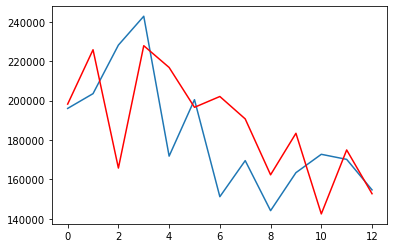

In [127]:
print_base_prediction_with_arima_by_product()

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [129]:
df_dummies = pd.get_dummies(data_aggregated_temp[['Product', 'Province']])
data_aggregated_temp_dummy_city_product = pd.merge(data_aggregated_temp, df_dummies, how="inner", left_index=True, right_index=True).drop(columns=['Product', 'Province'])
data_aggregated_temp_dummy_city_product.head()

,Period,Quantity,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,Price_ECILC_std,Open_ECILC_std,...,Province_SIVAS,Province_TEKIRDAG,Province_TOKAT,Province_TRABZON,Province_TUNCELI,Province_USAK,Province_VAN,Province_YALOVA,Province_YOZGAT,Province_ZONGULDAK
0,201701,346,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,0.043725,0.004673,...,0,0,0,0,0,0,0,0,0,0
1,201701,4838,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,0.043725,0.004673,...,0,0,0,0,0,0,0,0,0,0
2,201701,1004,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,0.043725,0.004673,...,0,0,0,0,0,0,0,0,0,0
3,201701,20,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,0.043725,0.004673,...,0,0,0,0,0,0,0,0,0,0
4,201701,910,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,0.043725,0.004673,...,0,0,0,0,0,0,0,0,0,0


In [130]:
def linear_regression_test():
    X = data_aggregated_temp_dummy_city_product.drop(['Quantity'], axis = 1)
    y = data_aggregated_temp_dummy_city_product.Quantity
    
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 0)
    lr = LinearRegression().fit(X_train,y_train)
    
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)

    print(lr.score(X_test,y_test))

In [132]:
def linear_regression_with_polynomial_features_test():
    X = data_aggregated_temp_dummy_city_product.drop(['Quantity'], axis = 1)
    y = data_aggregated_temp_dummy_city_product.Quantity
    quad = PolynomialFeatures (degree = 2)
    x_quad = quad.fit_transform(X)

    X_train,X_test,y_train,y_test = train_test_split(x_quad,y, random_state = 0)

    plr = LinearRegression().fit(X_train,y_train)

    y_train_pred = plr.predict(X_train)
    y_test_pred = plr.predict(X_test)

    print(plr.score(X_test,y_test))

In [133]:
#linear_regression_with_polynomial_features_test()

In [140]:
def random_forest_regressor_test(n_estimators=100, max_depth=None, min_samples_leaf=1):
    
    X = data_aggregated_temp_dummy_city_product.drop(['Quantity'], axis = 1)
    y = data_aggregated_temp_dummy_city_product.Quantity
    
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 0)
    
    
    forest = RandomForestRegressor(n_estimators = n_estimators,
                                   criterion = 'mse',
                                   max_depth = max_depth,
                                   min_samples_leaf = min_samples_leaf,
                                   random_state = 1,
                                   n_jobs = -1)
    forest.fit(X_train,y_train)
    forest_train_pred = forest.predict(X_train)
    forest_test_pred = forest.predict(X_test)

    print('RMSE train data: %.3f, RMSE test data: %.3f' % (
    math.sqrt(mean_squared_error(y_train,forest_train_pred)),
    math.sqrt(mean_squared_error(y_test,forest_test_pred))))
    print('R2 train data: %.3f, R2 test data: %.3f' % (
    r2_score(y_train,forest_train_pred),
    r2_score(y_test,forest_test_pred)))

In [143]:
linear_regression_test()

0.5773225283135666


In [141]:
random_forest_regressor_test()

RMSE train data: 146.356, RMSE test data: 453.765
R2 train data: 0.992, R2 test data: 0.935


In [142]:
random_forest_regressor_test(max_depth=4)

RMSE train data: 692.257, RMSE test data: 760.489
R2 train data: 0.817, R2 test data: 0.818


## Resources & References

1. Coordinates json file for the cities of Turkey:
   - https://github.com/cihadturhan/tr-geojson/tree/master/geo
2. An open source geographical heat map library used for data visualization
   - https://github.com/python-visualization/folium
3. ECILC / eczacibasi ilac monthly historical data
   - https://www.investing.com/equities/eczacibasi-ilac-historical-data
4. Borsa Istanbul monthly historical data
   - https://www.investing.com/indices/ise-100
5. DEVA Holding monthly historical data
   - https://www.investing.com/equities/deva-holding
6. Selçuk Ecza Deposu monthly historical data
   - https://www.investing.com/equities/selcuk-ecza-deposu
7. TUIK Gross Domestic Product By City (2018)
   - https://biruni.tuik.gov.tr/medas/?kn=116&locale=tr
8. TUIK Average Life Expectancy By City
   - http://www.tuik.gov.tr/PreIstatistikTablo.do?istab_id=2294
9. TUIK Population By City (2018)
   - http://www.tuik.gov.tr/PreIstatistikTablo.do?istab_id=1590
10. TUIK Population Growth Rate And Population Density By City (2017-2019)
   - http://www.tuik.gov.tr/PreIstatistikTablo.do?istab_id=1591
11. 1 - EnGenius Proje Sunumu.pdf
12. TUIK Children Count by Age And City (2017-2019)
   - https://biruni.tuik.gov.tr/medas/?kn=206&locale=tr
13. Prostate cancer incidence in Turkey: an epidemiological study (Zorlu et al., 2014)
   - https://pubmed.ncbi.nlm.nih.gov/25422189/
14. Prostate Enlargement According To Group of Age (Prof. Dr. Murat BİNBAY, 2010) 
   - https://www.memorial.com.tr/saglik-rehberleri/prostat-nedir-prostat-tedavisi-nasil-yapilir/
15. XALFU XL - Prospectus
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/XALFU-KT.pdf
16. XALFU XL - Brief Product Information
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/XALFU-KUB.pdf
17. ARVİLA® 250 mg tablet - Prospectus
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/ARVILA_KT.pdf
18. ARVİLA® 250 mg tablet - Brief Product Information
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/ARVILA_KUB.pdf
19. TUIK Retail Purchases Monthly Change With WAT Without Seasonal Influences Base 2015 Prices
   - https://biruni.tuik.gov.tr/medas/?kn=70&locale=tr
20. Law No. 6197 on Permacies and Pharmacists, Article 24 and 28
   - https://www.mevzuat.gov.tr/MevzuatMetin/1.3.6197.pdf
21. Pharmaceuticals and Medical Considerations Law No. 1262, Article 2 Clause B Subsection IV
   - https://www.mevzuat.gov.tr/MevzuatMetin/1.3.1262.pdf
22. TUIK Population Data by City Gender And Age Groups (2017-2019)
   - https://biruni.tuik.gov.tr/medas/?kn=95&locale=tr
23. An Open Source Python Library For Google Trends
   - https://pypi.org/project/pytrends/
24. Capital Market Law, Article 106
   - https://www.mevzuat.gov.tr/MevzuatMetin/1.5.6362.pdf
25. Random Forest Regressor Documentation
   - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
26. Google Search Trends Predicting Disease Outbreaks: An Analysis from India (Verma et al., 2018)
   - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6230529/

<font color='Navy'>
<font color='RoyalBlue'>
#font colors hidden above